<a href="https://colab.research.google.com/github/madanjha/Machine-Learning/blob/main/Nexflix_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recommendation System for Netflix Prize Dataset using SVD

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

# To load the 'combined_data_1'

In [11]:
# Reading dataset file
dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/combined_data_1.txt',header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
#not named---->we are naming the columns

# Convert Ratings column to a float
dataset['Rating'] = dataset['Rating'].astype(float)
#3
#3.5----->float--->rating column



In [12]:
#To print the datatype of columns
dataset.dtypes

,0
Cust_Id,object
Rating,float64


In [13]:
#To inspect the shape of the datset
dataset.shape



(24058263, 2)

In [14]:
#To print the head of dataset
dataset.head()

#1:----->1st movie
#1xyz rows

,Cust_Id,Rating
0,1:,NaN
1,1488844,3.0
2,822109,5.0
3,885013,4.0
4,30878,4.0


In [15]:
#To find the distribution of different ratings in the datset
p = dataset.groupby('Rating')['Rating'].agg(['count'])
p

,count
Rating,
1.0,1118186
2.0,2439073
3.0,6904181
4.0,8085741
5.0,5506583


In [16]:
# get movie count by counting nan values

movie_count = dataset.isnull().sum()[1]

movie_count

#4499 total number of movies present in dataset

<ipython-input-16-8940da6583b8>:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  movie_count = dataset.isnull().sum()[1]


4499

In [17]:
# get customer count
cust_count = dataset['Cust_Id'].nunique()-movie_count

cust_count

470758

In [18]:
# get rating count

rating_count = dataset['Cust_Id'].count() - movie_count

rating_count

24053764

## To plot the distribution of the ratings in as a bar plot

Text(0.5, 1.0, 'Total pool: 4499 Movies, 470758 customers, 24053764 ratings given')

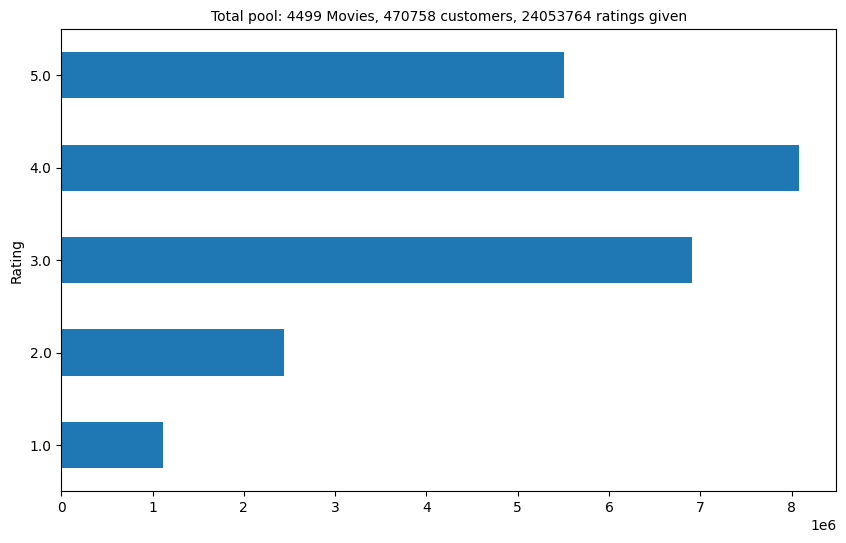

In [19]:
ax = p.plot(kind = 'barh', legend = False, figsize = (10,6))
plt.title(f'Total pool: {movie_count} Movies, {cust_count} customers, {rating_count} ratings given', fontsize=10)


# To create a numpy array containing movie ids corresponding to the rows in the 'ratings' dataset

In [20]:
# To count all the 'nan' values in the Ratings column in the 'ratings' dataset
df_nan = pd.DataFrame(pd.isnull(dataset.Rating))

df_nan.head()

,Rating
0,True
1,False
2,False
3,False
4,False


In [21]:
# To store the index of all the rows containing 'nan' values
df_nan = df_nan[df_nan['Rating'] == True]
df_nan.shape

(4499, 1)

In [22]:
# To reset the index of the dataframe
df_nan = df_nan.reset_index()
df_nan.head()

,index,Rating
0,0,True
1,548,True
2,694,True
3,2707,True
4,2850,True


In [23]:
#To create a numpy array containing movie ids according the 'ratings' dataset

movie_np = []
movie_id = 1
#into tuple
for i,j in zip(df_nan['index'][1:],df_nan['index'][:-1]):
    # numpy approach
    temp = np.full((1,i-j-1), movie_id)
    movie_np = np.append(movie_np, temp)
    movie_id += 1

# Account for last record and corresponding length
# numpy approach
last_record = np.full((1,len(dataset) - df_nan.iloc[-1, 0] - 1),movie_id)
movie_np = np.append(movie_np, last_record)

print(f'Movie numpy: {movie_np}')
print(f'Length: {len(movie_np)}')

Movie numpy: [1.000e+00 1.000e+00 1.000e+00 ... 4.499e+03 4.499e+03 4.499e+03]
Length: 24053764


In [24]:
#To append the above created array to the datset after removing the 'nan' rows
dataset = dataset[pd.notnull(dataset['Rating'])]#movies count so nan
dataset['Movie_Id'] = movie_np.astype(int)
dataset['Cust_Id'] =dataset['Cust_Id'].astype(int)
print('-Dataset examples-')
dataset.head()

-Dataset examples-


,Cust_Id,Rating,Movie_Id
1,1488844,3.0,1
2,822109,5.0,1
3,885013,4.0,1
4,30878,4.0,1
5,823519,3.0,1


In [25]:
dataset.shape

(24053764, 3)

# Data Cleaning

In [26]:
f = ['count','mean']
#count and mean

In [27]:
#To create a list of all the movies rated less often(only include top 30% rated movies)
dataset_movie_summary = dataset.groupby('Movie_Id')['Rating'].agg(f)

dataset_movie_summary.index = dataset_movie_summary.index.map(int)

movie_benchmark = round(dataset_movie_summary['count'].quantile(0.7),0)

drop_movie_list = dataset_movie_summary[dataset_movie_summary['count'] < movie_benchmark].index

print('Movie minimum times of review: {}'.format(movie_benchmark))

Movie minimum times of review: 1799.0


In [28]:
#To create a list of all the inactive users(users who rate less often)
dataset_cust_summary = dataset.groupby('Cust_Id')['Rating'].agg(f) #mean and count of customer id
dataset_cust_summary.index = dataset_cust_summary.index.map(int) #integer format
cust_benchmark = round(dataset_cust_summary['count'].quantile(0.7),0)
drop_cust_list = dataset_cust_summary[dataset_cust_summary['count'] < cust_benchmark].index
#                                           6                       <  5
#drop_cust_list[3,4]
print(f'Customer minimum times of review: {cust_benchmark}')

Customer minimum times of review: 52.0


In [33]:
print(f'Original Shape: {dataset.shape}')


Original Shape: (17337458, 3)


In [34]:
dataset = dataset[~dataset['Movie_Id'].isin(drop_movie_list)]
#in dataset --->in all movie ids------>if the whic ever  movies we put under drop list are present or not---
#if present drop /remove them
dataset = dataset[~dataset['Cust_Id'].isin(drop_cust_list)]
#removing all inactive users from our dataset
print('After Trim Shape: {}'.format(dataset.shape))

After Trim Shape: (17337458, 3)


In [35]:
print('-Data Examples-')
dataset.head()

-Data Examples-


,Cust_Id,Rating,Movie_Id
696,712664,5.0,3
697,1331154,4.0,3
698,2632461,3.0,3
699,44937,5.0,3
700,656399,4.0,3


# Create ratings matrix for 'ratings' matrix with Rows = userId, Columns = movieId

In [36]:
df_p = pd.pivot_table(dataset,values='Rating',index='Cust_Id',columns='Movie_Id')

print(df_p.shape)

(143458, 1350)


In [37]:
df_p.head()

Movie_Id,3,8,16,17,18,26,28,30,32,33,...,4472,4474,4478,4479,4485,4488,4490,4492,4493,4496
Cust_Id,,,,,,,,,,,,,,,,,,,,,
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,...,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,5.0,NaN,NaN,NaN,NaN,4.0,5.0,NaN,NaN,...,3.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN
79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,...,4.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN
97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
134,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### To load the movie_titles dataset

In [38]:
df_title = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/movie_titles.csv',
                      encoding="ISO-8859-1",
                      header=None,
                      names=['Movie_Id', 'Year', 'Name'],
                      on_bad_lines='skip') # or on_bad_lines=False for older pandas versions

df_title.set_index('Movie_Id', inplace=True)

print(df_title.head(10))
print(df_title.head(10))

            Year                          Name
Movie_Id                                      
1         2003.0               Dinosaur Planet
2         2004.0    Isle of Man TT 2004 Review
3         1997.0                     Character
4         1994.0  Paula Abdul's Get Up & Dance
5         2004.0      The Rise and Fall of ECW
6         1997.0                          Sick
7         1992.0                         8 Man
8         2004.0    What the #$*! Do We Know!?
9         1991.0      Class of Nuke 'Em High 2
10        2001.0                       Fighter
            Year                          Name
Movie_Id                                      
1         2003.0               Dinosaur Planet
2         2004.0    Isle of Man TT 2004 Review
3         1997.0                     Character
4         1994.0  Paula Abdul's Get Up & Dance
5         2004.0      The Rise and Fall of ECW
6         1997.0                          Sick
7         1992.0                         8 Man
8         200

### Run the following command in the Anaconda Prompt to install surprise package

In [40]:
# Load Reader library
reader = Reader()

In [41]:
dataset.head()

,Cust_Id,Rating,Movie_Id
696,712664,5.0,3
697,1331154,4.0,3
698,2632461,3.0,3
699,44937,5.0,3
700,656399,4.0,3


In [42]:
data = Dataset.load_from_df(dataset[['Cust_Id', 'Movie_Id', 'Rating']].head(100000), reader)

In [44]:
svd = SVD()

In [45]:
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=3, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9989  0.9919  1.0007  0.9972  0.0038  
MAE (testset)     0.7980  0.7890  0.7995  0.7955  0.0046  
Fit time          1.36    1.38    1.83    1.52    0.22    
Test time         0.37    0.15    0.28    0.27    0.09    


{'test_rmse': array([0.99892999, 0.99191958, 1.00073837]),
 'test_mae': array([0.797964  , 0.78903863, 0.79953789]),
 'fit_time': (1.3588078022003174, 1.3798134326934814, 1.8287079334259033),
 'test_time': (0.3705770969390869, 0.15435314178466797, 0.28344202041625977)}

In [46]:
dataset.head()

,Cust_Id,Rating,Movie_Id
696,712664,5.0,3
697,1331154,4.0,3
698,2632461,3.0,3
699,44937,5.0,3
700,656399,4.0,3


In [47]:
dataset_712664 = dataset[(dataset['Cust_Id'] == 712664) & (dataset['Rating'] == 5)]
dataset_712664 = dataset_712664.set_index('Movie_Id')
dataset_712664 = dataset_712664.join(df_title)['Name']
dataset_712664.head(10)

,Name
Movie_Id,
3,Character
79,The Killing
175,Reservoir Dogs
199,The Deer Hunter
241,North by Northwest
256,Ghost Dog: The Way of the Samurai
348,The Last Temptation of Christ
357,House of Sand and Fog
416,Elephant


### Train an SVD to predict ratings for user with userId = 1

In [48]:
user_712664 = df_title.copy()

In [49]:
user_712664 = user_712664.reset_index()

In [50]:
user_712664 = user_712664[~user_712664['Movie_Id'].isin(drop_movie_list)]


# getting full dataset
data = Dataset.load_from_df(dataset[['Cust_Id', 'Movie_Id', 'Rating']], reader)

#create a training set for svd
trainset = data.build_full_trainset()
svd.fit(trainset)

#Predict the ratings for user_712664
user_712664['Estimate_Score'] = user_712664['Movie_Id'].apply(lambda x: svd.predict(712664, x).est)

#Drop extra columns from the user_712664 data frame
user_712664 = user_712664.drop('Movie_Id', axis = 1)

# Sort predicted ratings for user_712664 in descending order
user_712664 = user_712664.sort_values('Estimate_Score', ascending=False)

#Print top 10 recommendations
print(user_712664.head(10))

        Year                            Name  Estimate_Score
4270  2002.0  Curb Your Enthusiasm: Season 3             5.0
1984  2004.0                Samurai Champloo             5.0
2067  1994.0          The Simpsons: Season 6             5.0
2389  1979.0      Alien: Collector's Edition             5.0
857   1954.0                   Seven Samurai             5.0
1597  1986.0     Aliens: Collector's Edition             5.0
2078  2002.0                         Firefly             5.0
32    2000.0  Aqua Teen Hunger Force: Vol. 1             5.0
711   2003.0              The Wire: Season 1             5.0
173   1992.0                  Reservoir Dogs             5.0
